#Header:

## Herman Franclin Tesso Tassang


#1. Decision stump by hand

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# set a seed to ensure reproducibility
seed = 42
rnd  = np.random.RandomState(seed)

# Matplotlib plotting settings
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib version: {}'.format(mp.__version__))

FONTSIZE = 16
params = {
         'axes.labelsize': FONTSIZE,
         'axes.titlesize': FONTSIZE,
         'xtick.labelsize':FONTSIZE,
         'ytick.labelsize':FONTSIZE}
plt.rcParams.update(params)

matplotlib version: 3.7.1


###1.1 Get and load the data

In [ ]:
file_path='/content/gdrive/MyDrive/Shortcut to courses materials/ML by hand/data_atlas_higgs_4lep/ATLAS_higgs_train.csv'
df=pd.read_csv(file_path)
df.head(5)

,Z1mass,Z2mass,detajj,massjj,l1pdgid,l1eta,l1phi,l1pt,l2pdgid,l2eta,...,l2pt,l3pdgid,l3eta,l3phi,l3pt,l4pdgid,l4eta,l4phi,l4pt,sample
0,68.515258,57.174385,4.283580,556.406882,-11,0.490221,-2.302279,68.776711,-11,0.910430,...,50.775758,11,-0.495413,-1.409834,28.700672,11,0.542029,-0.328558,17.054512,1
1,84.330551,25.551337,1.101106,266.768190,-11,1.291437,1.917571,77.658719,11,0.142028,...,61.922754,-13,0.208367,1.411837,30.645279,13,1.380638,0.300915,8.034711,-1
2,90.902327,30.404745,2.394863,211.879331,-13,0.702544,-0.946013,91.046750,13,0.958006,...,32.417166,11,0.385190,0.934649,17.942230,-11,0.672241,-1.410558,14.799019,-1
3,91.129112,26.609989,1.040268,56.235126,-11,-2.450392,3.123466,58.988305,11,-1.276226,...,30.001736,-13,-1.275654,0.280533,12.816265,13,-2.283192,-2.326921,11.448904,1
4,87.525977,32.304742,3.674720,351.241850,11,-1.303559,0.963711,66.502133,-11,-0.254885,...,26.519908,-13,-1.052104,0.041387,22.981393,13,0.099710,1.758643,12.038583,1


In [ ]:
#@title the  reduced dataset

index= ['detajj', 'massjj','sample']
train=df[index]
train

,detajj,massjj,sample
0,4.283580,556.406882,1
1,1.101106,266.768190,-1
2,2.394863,211.879331,-1
3,1.040268,56.235126,1
4,3.674720,351.241850,1
...,...,...,...
34995,0.139980,60.332091,-1
34996,4.084168,321.179218,-1
34997,0.471683,32.555787,-1
34998,0.042897,122.989028,-1


In [ ]:
train.dtypes

detajj    float64
massjj    float64
sample      int64
dtype: object

In [ ]:
print('the training set consists of {} events and {} features'.format(train.shape[0],train.shape[1]-1))
print('number of class={}'.format(len(train['sample'].unique())))

the training set consists of 35000 events and 2 features
number of class=2


In [ ]:
class_values=train['sample'].unique()
class_values # print the encode class values.(1='signal' ; -1='background')

array([ 1, -1])

### 1.2 Compute the Gini index

In [ ]:
def Gini_index(node,class_val,eps=10e-7):

  """The function compute the Dini impurity of a node in a decision tree
      Arguments:
      node(1D array): number of data point in the current node
      class_val(1D array ): class values
      eps (float): small number use to prevent division by zero """
  p=0
  for i in range(len(class_val)):            # go over the classes
    num_class_i=(node==class_val[i]).sum()   # identify all the data points belonging to a given class
    p += (num_class_i/(len(node)+eps))**2    # compute the sum of  square probabilities ( formula from the course note)
  gini_impurity=1-p                          # final result (gini_index )
  return gini_impurity


### 1.3 Calculate the cost

In [ ]:
def Cost(l_node,r_node,class_val):

  """The function computes the Cost at a depth level of a decision tree
  Arguments:
  l_node (1D array): number of data points in the left node
  r_node (1D array ): number of data points in the right node
  class_val (array): class values"""

  N=len(l_node)+len(r_node)                                            # total number of samples for the current depth
  cost=len(l_node)/N*Gini_index(l_node,class_val) + len(r_node)/N*Gini_index(r_node,class_val) # cost formula
  return cost

### 1.4 Main function: code a Decision Stump

In [ ]:
def decision_stumper(df,input_name,class_name,class_val):
  """
  The function implement the decision Stump algorithm
  Arguments:
  df (DataFrame): the dataset
  input_name ( list ): a list data structure containing the name of the features of interest
  class_name (string): label (target) name in the DataFrame df
  class_val (1D array ): array containing encode class values
  """
  opt_threshold={}        # empty dictionnary create to store the optimal threshold and the minimal cost  for each feature
  for input in input_name:   # loop over the features
    history=[]
    sorted_var=np.sort ( np.array(df[input]).flatten() )  # sorted the feature values to define the list of experimental threshold
    threshods=[(sorted_var[i] + sorted_var[i+1]) / 2 for i in range(0, len(sorted_var)-1)]  # create the list of threshold as a "pair mean" of the sorted feature values
    for t in threshods:                      # loop over the thresholds
      l_node=df[class_name][df[input]<=t]    # split the data according to the current threshold
      r_node=df[class_name][df[input]>t]
      c=Cost(l_node,r_node,class_val)        # comput the cost for this threshold
      history.append([t,c])                  # store every threshold along with their associated cost.
    h=np.array(history)
    opt_threshold['{}_threshold'.format(input)]=[ h[:,0][h[:,1]==min(h[:,1])], min(h[:,1]) ] # extract the threshold associate to the minimal cost [opt_threshold, min_cost]
  return opt_threshold

In [ ]:
#@title Call the decision Stumper
result=decision_stumper(df=train,input_name=['detajj','massjj'],class_name='sample',class_val=class_values)

In [ ]:
#@title result
print('for the variable "detajj":\n the optimal threshold is detajj_threshold={} and the associate cost is detajj_Cost={}'.format(result['detajj_threshold'][0][0],result['detajj_threshold'][1]))
print('')
print('for the variable "massjj":\n the optimal threshold is  massjj_threshold={} and the associate cost is massjj_Cost={}'.format(result['massjj_threshold'][0][0],result['massjj_threshold'][1]))

for the variable "detajj":
 the optimal threshold is detajj_threshold=2.6039083003997803 and the associate cost is detajj_Cost=0.4657548422235751

for the variable "massjj":
 the optimal threshold is  massjj_threshold=214.21446583027145 and the associate cost is massjj_Cost=0.4560585800695958


### Conclusion

We will use the **massjj** feature for the  final cut for your decision stump because we achieve the lower cost when using its optimal threshold for the the cut.

In [ ]:
#@title get the optimal threshold for the "massjj" variable
t_massjj=result['massjj_threshold'][0][0]
t_massjj

214.21446583027145

In [ ]:
file_path2='/content/gdrive/MyDrive/Shortcut to courses materials/ML by hand/data_atlas_higgs_4lep/ATLAS_higgs_test.csv'
test=pd.read_csv(file_path2)

### 1.5 Plot the cut

In [ ]:
# GLOBAL VARIABLES
XNAME = 'detajj'; XLABEL = r'$|\Delta\eta_{jj}|$'
YNAME = 'massjj'; YLABEL = r'$m_{jj}$ (GeV)'

inputs= [XNAME, YNAME] ;

XBINS = 5 ; XMIN = 0 ; XMAX = 5    ; XSTEP = 1
YBINS = 5 ; YMIN = 0 ; YMAX = 1000 ; YSTEP = 200

# Creating reduced datasets with detajj & massjj only
X_train = train[inputs] ; y_train = train['sample']
X_test  =  test[inputs] ; y_test  =  test['sample']

In [ ]:
#@title split the data into signal (VBF) and background (ggF)
sig=train[train['sample']==1]
bkg=train[train['sample']==-1]

In [ ]:
def plot_scatter(sig, bkg, y_threshold=False,x_threshold=False,
              xname=XNAME, xlabel=XLABEL, xmin=XMIN, xmax=XMAX, xstep=XSTEP,
              yname=YNAME, ylabel=YLABEL, ymin=YMIN, ymax=YMAX, ystep=YSTEP,
              fgsize=(6, 6), ftsize=FONTSIZE, alpha=0.3, title="Scatter plot"):

  fig, ax = plt.subplots(figsize=fgsize)

  # Annotate x-axis
  ax.set_xlim(xmin, xmax)
  ax.set_xlabel(xlabel)
  ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))

  # Annotate y-axis
  ax.set_ylim(ymin, ymax)
  ax.set_ylabel(ylabel)
  ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=15, c='b', alpha=alpha, label='VBF')
  ax.scatter(bkg[xname], bkg[yname], marker='*', s= 5, c='r', alpha=alpha, label='ggf')
  if y_threshold :                                             # if massjj feature is used for decision stump
    ax.axhline(y=y_threshold, xmin=0, xmax=1, color='green',label='cut',linestyle='--', linewidth=3)
  if x_threshold:                                              # if detajj is used for decision stump
    ax.axvline(x=x_threshold, ymin=0, ymax=1,color='green',label='cut',linestyle='-.', linewidth=3)

  # Legend and plot:
  ax.legend(fontsize=ftsize, bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False)
  ax.set_title(title, pad=20)
  plt.show()

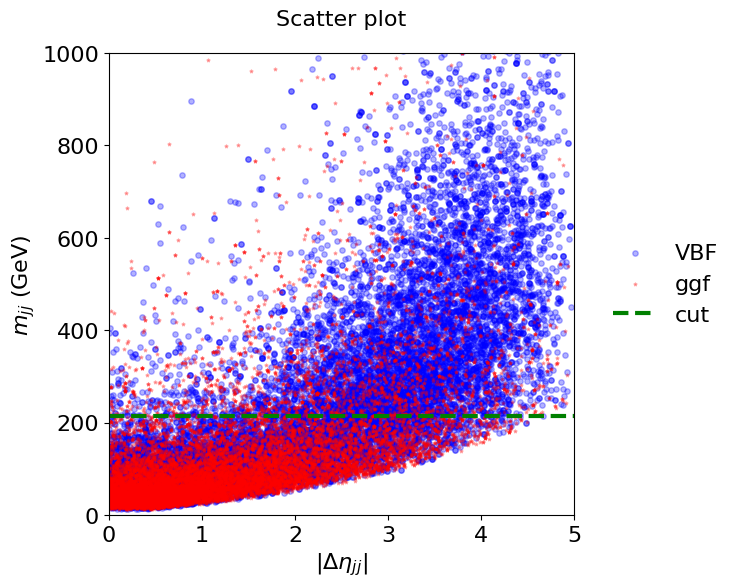

In [ ]:
plot_scatter(sig,bkg,y_threshold=t_massjj)

#2. Plotting mission: the overtraining check

###2.1 Understanding of the plot
Describe the plot and explain why this is called an “overtraining check” plot. Importance will be given to the clarity of your answer.

Answer:

The plot inspects the classifier (SVM) ouput distribution for the test and training samples. I thing that the first intuition is that the two plots should agree (agreement between training and testing plot of response  distribution) if the training converges without overtraining. So the plot evaluates how well test and train match. Therefore it can be use to detect overtraining.

### 2.2 Reproducing the plot

In [ ]:
### Plotting macro

def plot_overtraining_check(classifier,X,y,pos_class=1,title='overtraining check'):
  X_train,X_test=X[0],X[1]
  y_train,y_test=y[0],y[0]

  # split dataset into real cathegory (signal=VBF and background=ggF)
  X_train_signal=X_train[y_train==pos_class]
  X_train_bacground=X_train[y_train!=pos_class]

  X_test_signal=X_test[y_test==pos_class]
  X_test_background=X_test[y_test!=pos_class]

  # train the classifier
  classifier.fit(X_train,y_train)

  # get classifier predictions (response) for signal events in training and testing datasets
  train_signal_resp=classifier.predict_proba(X_train_signal)[:,1]
  test_signal_resp=classifier.predict_proba(X_test_signal)[:,1]

  # get classifier predictions (response) for background events in training and testing datasets
  train_backg_resp=classifier.predict_proba(X_train_bacground)[:,1]
  test_backg_resp=classifier.predict_proba(X_test_background)[:,1]

  #Plot MVA distribution
  plt.figure(figsize=(8, 6))
  plt.xlim(0,1)
  plt.hist(train_signal_resp, bins=25, histtype='step', label='Signal (Training)', density=1,color='blue')
  plt.hist(train_backg_resp, bins=25, histtype='step', label='Background (Training)', density=1,color='red')
  plt.hist(test_signal_resp, bins=25, histtype='stepfilled', color='blue', linestyle='--', label='Signal (Testing)', density=1,alpha=0.4,edgecolor='none')
  plt.hist(test_backg_resp, bins=25, histtype='stepfilled', color='red', linestyle='--', label='Background (Testing)', density=1,alpha=0.4,edgecolor='none')
  plt.xlabel('Classifier score')
  plt.ylabel('Normalized unit')
  plt.title(title)
  plt.legend(title="legend",
                       bbox_to_anchor=(1.06, 0.3), loc="center left",
                       title_fontsize=16, frameon=False)
  plt.grid(False)
  plt.show()


In [ ]:
#@title create a classifier : Decision tree with max depth=2
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(max_depth=2,random_state=41)

<ipython-input-42-a9c1270edd9c>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_signal=X_test[y_test==pos_class]
<ipython-input-42-a9c1270edd9c>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_background=X_test[y_test!=pos_class]


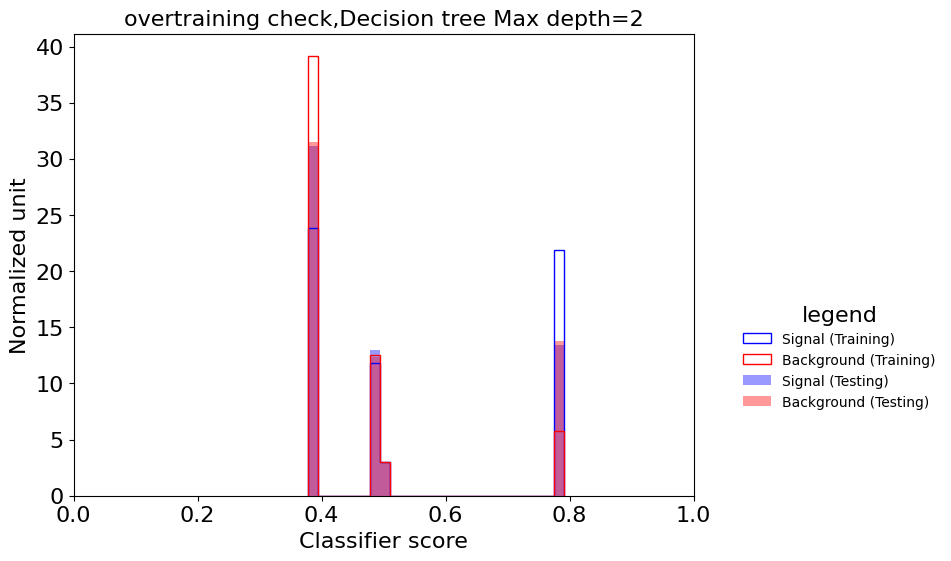

In [ ]:
#@title plot the overtraining check for the classifier
plot_overtraining_check(classifier=clf,X=[X_train,X_test],y=[y_train,y_test],pos_class=1,title='overtraining check,Decision tree Max depth=2')

### 2.3 Using the plot

In [ ]:
#@title Create a random forest classifier with 100 estimators
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(n_estimators=100)

<ipython-input-42-a9c1270edd9c>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_signal=X_test[y_test==pos_class]
<ipython-input-42-a9c1270edd9c>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_background=X_test[y_test!=pos_class]


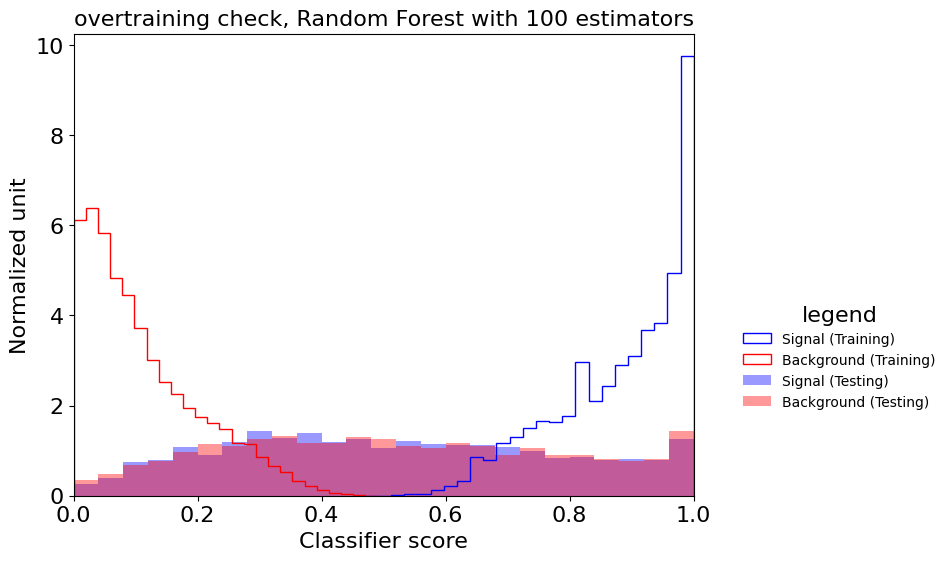

In [ ]:
#@title plot the overtraining check for this classifier
plot_overtraining_check(classifier=rf_clf,X=[X_train,X_test],y=[y_train,y_test],pos_class=1,title='overtraining check, Random Forest with 100 estimators')

### Observations:

The response distributions of testing and training samples completely disagree; we notice a significant performance on the training samples compare to the testing samples, indicating that the classifier is overtraining.

In [ ]:
#@title Create a random forest classifier with 100 estimators and Max_leaf_nodes=32
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(max_leaf_nodes=32)

<ipython-input-42-a9c1270edd9c>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_signal=X_test[y_test==pos_class]
<ipython-input-42-a9c1270edd9c>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_test_background=X_test[y_test!=pos_class]


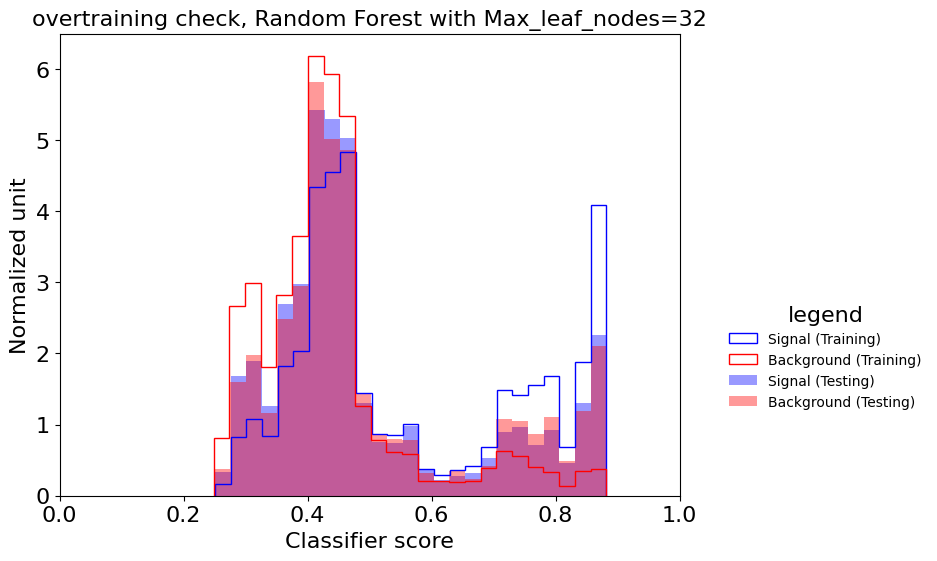

In [ ]:
#@title plot the overtraining check for this classifier
plot_overtraining_check(classifier=rf_clf,X=[X_train,X_test],y=[y_train,y_test],pos_class=1,title='overtraining check, Random Forest with Max_leaf_nodes=32')

### Observation:

The plot of the Performance distributions of training and testing samples aligns. However they still don't match enought to claim the performance of the classifier.